# **MBTI 분류 - 이화여대 1839 팀**

In [ ]:
!pip install konlpy
!pip install gspread
import gspread
from google.colab import drive
drive.mount('/content/drive')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 19.4 MB 1.3 MB/s 
     |████████████████████████████████| 453 kB 68.5 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Mounted at /content/drive


In [ ]:
!pip install pandas
!pip install matplotlib
!pip install tqdm
!pip install tensorflow
!pip install numpy
import pandas as pd
import urllib.request
import matplotlib.pyplot as plt
import re
from konlpy.tag import Okt
from tqdm import tqdm
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# **데이터 로드**

In [ ]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/parkjimin00-a11y/1839_gross/main/3-LSTM/mbti_data.txt", filename="mbti_data.txt")

('rating.txt', <http.client.HTTPMessage at 0x7f7300c5b710>)

In [ ]:
pd_data = pd.read_table('mbti_data.txt')

## **텍스트 전처리**

In [ ]:
pd_data['내용'] = pd_data['내용'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]", "") 
pd_data['내용'] = pd_data['내용'].str.replace('^ +', "") # 공백은 empty 값으로 변경
pd_data['내용'].replace('', np.nan, inplace=True) # 공백은 Null 값으로 변경
pd_data = pd_data.dropna(subset = ['내용']).dropna(subset = ['e/i', 'n/s', 'f/t', 'p/j'], how = 'all')
print('전처리 후 테스트용 샘플의 개수 :',len(pd_data))

stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','을','으로','자','에','와','한','하다']

okt = Okt()

data = []
for sentence in tqdm(pd_data['내용']):
    tokenized_sentence = okt.morphs(sentence, stem=True) # 토큰화
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어 제거
    data.append(stopwords_removed_sentence)






/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  


전처리 후 테스트용 샘플의 개수 : 33141


100%|██████████| 33141/33141 [03:14<00:00, 170.69it/s]


In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(data)
print(tokenizer.word_index)
print(tokenizer.word_counts.items())

{'있다': 1, '같다': 2, '사람': 3, '저': 4, '것': 5, '생각': 6, '안': 7, '없다': 8, '보다': 9, '적': 10, '요': 11, '말': 12, '않다': 13, '되다': 14, '좋다': 15, '제': 16, '때': 17, '그렇다': 18, '아니다': 19, '자다': 20, '좋아하다': 21, '거': 22, '그': 23, '하고': 24, '내': 25, '인': 26, '해주다': 27, '너무': 28, '로': 29, '다': 30, '못': 31, '싶다': 32, '나': 33, '이다': 34, '연락': 35, '들다': 36, '더': 37, '많다': 38, '고': 39, '그냥': 40, '받다': 41, '에서': 42, '게': 43, '친구': 44, '일': 45, '수': 46, '맞다': 47, '만': 48, '마음': 49, '감정': 50, '만나다': 51, '많이': 52, 'ㅎㅎ': 53, '한테': 54, '상대': 55, '가다': 56, '진짜': 57, '시간': 58, '얘기': 59, 'ㅋㅋ': 60, '전': 61, '표현': 62, '해': 63, '분': 64, '알다': 65, '에게': 66, 'ㅋㅋㅋ': 67, '면': 68, '자기': 69, '근데': 70, '모르다': 71, '어떻다': 72, '정말': 73, '이렇다': 74, '관심': 75, '오다': 76, 'ㅠㅠ': 77, '걸': 78, '싫다': 79, '정도': 80, '하': 81, '느끼다': 82, '상대방': 83, '다른': 84, '호감': 85, '느낌': 86, '대화': 87, '사랑': 88, '인데': 89, '뭐': 90, '그리고': 91, '주다': 92, '랑': 93, '해보다': 94, '본인': 95, '유형': 96, '힘들다': 97, '건': 98, '행동': 99, '서': 100, '이라': 101, '상황': 102, 'ㅋ

In [ ]:
threshold = 3
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

vocab_size = total_cnt - rare_cnt + 1
tokenizer = Tokenizer(vocab_size) # 빈도수 3 미만인 단어는 제거
tokenizer.fit_on_texts(data)
data = tokenizer.texts_to_sequences(data)

In [ ]:
data_s = data

# **E/I 분류 데이터의 null 값 삭제 작업 및 텍스트의 길이 맞추기**

In [ ]:
data_y_ei = np.array(pd_data['e/i'])  ################   mbti의 4가지 카테고리에 따라 'e/i' 또는 'n/s' 또는 'f/t' 또는 'p/j'

drop_ei = [index for index, sentence in enumerate(data_y_ei) if sentence != 0 and sentence != 1 ]

data_ei = np.delete(data_s, drop_ei, axis=0)
data_y_ei = np.delete(data_y_ei, drop_ei, axis=0)

data_y_ei = data_y_ei.astype(float)

drop_ei_1 = [index for index, sentence in enumerate(data_ei) if len(sentence) < 1]

data_ei = np.delete(data_ei, drop_ei_1, axis=0)
data_y_ei = np.delete(data_y_ei, drop_ei_1, axis=0)



/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:4454: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asarray(arr)


In [ ]:
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))*100))

max_len = 100
below_threshold_len(max_len, data_ei)

# 전체 데이터의 길이는 100으로 맞춘다.
data_ei = pad_sequences(data_ei, maxlen = max_len)

전체 샘플 중 길이가 100 이하인 샘플의 비율: 97.35297789986265


# **N/S 분류 데이터의 null 값 삭제 작업 및 텍스트의 길이 맞추기**

In [ ]:
data_y_ns = np.array(pd_data['n/s'])  ################   mbti의 4가지 카테고리에 따라 'e/i' 또는 'n/s' 또는 'f/t' 또는 'p/j'

drop_ns = [index for index, sentence in enumerate(data_y_ns) if sentence != 0 and sentence != 1 ]

data_ns = np.delete(data_s, drop_ns, axis=0)
data_y_ns = np.delete(data_y_ns, drop_ns, axis=0)

data_y_ns = data_y_ns.astype(float)

drop_ns_1 = [index for index, sentence in enumerate(data_ns) if len(sentence) < 1]

data_ns = np.delete(data_ns, drop_ns_1, axis=0)
data_y_ns = np.delete(data_y_ns, drop_ns_1, axis=0)



/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:4454: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asarray(arr)


In [ ]:
max_len = 100
below_threshold_len(max_len, data_ns)

# 전체 데이터의 길이는 100으로 맞춘다.
data_ns = pad_sequences(data_ns, maxlen = max_len)

전체 샘플 중 길이가 100 이하인 샘플의 비율: 97.37562686521244


# **F/T 분류 데이터의 null 값 삭제 작업 및 텍스트의 길이 맞추기**

In [ ]:
data_y_ft = np.array(pd_data['f/t'])  ################   mbti의 4가지 카테고리에 따라 'e/i' 또는 'n/s' 또는 'f/t' 또는 'p/j'

drop_ft = [index for index, sentence in enumerate(data_y_ft) if sentence != 0 and sentence != 1 ]

data_ft = np.delete(data_s, drop_ft, axis=0)
data_y_ft = np.delete(data_y_ft, drop_ft, axis=0)

data_y_ft = data_y_ft.astype(float)

drop_ft_1 = [index for index, sentence in enumerate(data_ft) if len(sentence) < 1]

data_ft = np.delete(data_ft, drop_ft_1, axis=0)
data_y_ft = np.delete(data_y_ft, drop_ft_1, axis=0)



/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:4454: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asarray(arr)


In [ ]:
max_len = 100
below_threshold_len(max_len, data_ft)

# 전체 데이터의 길이는 100으로 맞춘다.
data_ft = pad_sequences(data_ft, maxlen = max_len)

전체 샘플 중 길이가 100 이하인 샘플의 비율: 97.37442218798151


# **P/J 분류 데이터의 null 값 삭제 작업 및 텍스트의 길이 맞추기**

In [ ]:
data_y_pj = np.array(pd_data['p/j'])  ################   mbti의 4가지 카테고리에 따라 'e/i' 또는 'n/s' 또는 'f/t' 또는 'p/j'

drop_pj = [index for index, sentence in enumerate(data_y_pj) if sentence != 0 and sentence != 1 ]

data_pj = np.delete(data_s, drop_pj, axis=0)
data_y_pj = np.delete(data_y_pj, drop_pj, axis=0)

data_y_pj = data_y_pj.astype(float)

drop_pj_1 = [index for index, sentence in enumerate(data_pj) if len(sentence) < 1]

data_pj = np.delete(data_pj, drop_pj_1, axis=0)
data_y_pj = np.delete(data_y_pj, drop_pj_1, axis=0)



/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:4454: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asarray(arr)


In [ ]:
max_len = 100
below_threshold_len(max_len, data_pj)

# 전체 데이터의 길이는 100으로 맞춘다.
data_pj = pad_sequences(data_pj, maxlen = max_len)

전체 샘플 중 길이가 100 이하인 샘플의 비율: 97.38092300098717


# **E/I 분류 학습**

In [ ]:
from tensorflow.keras.layers import Embedding, Dense, LSTM, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from keras.regularizers import l2
es_ei = EarlyStopping(monitor='val_acc', mode='max', verbose=1, patience=4)
mc_ei = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model_ei = Sequential()
model_ei.add(Embedding(vocab_size, 100))
model_ei.add(LSTM(128, kernel_regularizer=l2(0.0005), recurrent_regularizer=l2(0.0005), bias_regularizer=l2(0.0005)))
model_ei.add(Dropout(0.5))
model_ei.add(Dense(1, activation='sigmoid', kernel_regularizer=l2(0.0005)))

opt = Adam(learning_rate=5e-4)
model_ei.compile(optimizer=opt, loss='binary_crossentropy', metrics=['acc'])
history = model_ei.fit(data_ei, data_y_ei, epochs=15, callbacks=[es_ei, mc_ei], batch_size=64, validation_split=0.2)
loaded_model_ei = load_model('best_model.h5')

Epoch 1/15
398/401 [============================>.] - ETA: 0s - loss: 0.7593 - acc: 0.5955
Epoch 1: val_acc improved from -inf to 0.60752, saving model to best_model.h5
401/401 [==============================] - 13s 14ms/step - loss: 0.7592 - acc: 0.5956 - val_loss: 0.7100 - val_acc: 0.6075
Epoch 2/15
399/401 [============================>.] - ETA: 0s - loss: 0.6608 - acc: 0.6654
Epoch 2: val_acc improved from 0.60752 to 0.64295, saving model to best_model.h5
401/401 [==============================] - 5s 12ms/step - loss: 0.6606 - acc: 0.6657 - val_loss: 0.6774 - val_acc: 0.6429
Epoch 3/15
398/401 [============================>.] - ETA: 0s - loss: 0.5947 - acc: 0.7098
Epoch 3: val_acc improved from 0.64295 to 0.65215, saving model to best_model.h5
401/401 [==============================] - 5s 12ms/step - loss: 0.5948 - acc: 0.7095 - val_loss: 0.6735 - val_acc: 0.6522
Epoch 4/15
396/401 [============================>.] - ETA: 0s - loss: 0.5531 - acc: 0.7384
Epoch 4: val_acc improved fro

# **N/S 분류 학습**

In [ ]:
es_ns = EarlyStopping(monitor='val_acc', mode='max', verbose=1, patience=4)
mc_ns = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model_ns = Sequential()
model_ns.add(Embedding(vocab_size, 100))
model_ns.add(LSTM(128, kernel_regularizer=l2(0.0005), recurrent_regularizer=l2(0.0005), bias_regularizer=l2(0.0005)))
model_ns.add(Dropout(0.5))
model_ns.add(Dense(1, activation='sigmoid', kernel_regularizer=l2(0.0005)))

opt = Adam(learning_rate=5e-4)
model_ns.compile(optimizer=opt, loss='binary_crossentropy', metrics=['acc'])

history = model_ns.fit(data_ns, data_y_ns, epochs=15, callbacks=[es_ns, mc_ns], batch_size=64, validation_split=0.2)
loaded_model_ns = load_model('best_model.h5')

Epoch 1/15
405/407 [============================>.] - ETA: 0s - loss: 0.7582 - acc: 0.5770
Epoch 1: val_acc improved from -inf to 0.63606, saving model to best_model.h5
407/407 [==============================] - 7s 13ms/step - loss: 0.7580 - acc: 0.5771 - val_loss: 0.6867 - val_acc: 0.6361
Epoch 2/15
406/407 [============================>.] - ETA: 0s - loss: 0.6473 - acc: 0.6822
Epoch 2: val_acc improved from 0.63606 to 0.65498, saving model to best_model.h5
407/407 [==============================] - 5s 12ms/step - loss: 0.6473 - acc: 0.6821 - val_loss: 0.6655 - val_acc: 0.6550
Epoch 3/15
403/407 [============================>.] - ETA: 0s - loss: 0.5873 - acc: 0.7214
Epoch 3: val_acc improved from 0.65498 to 0.66221, saving model to best_model.h5
407/407 [==============================] - 5s 11ms/step - loss: 0.5878 - acc: 0.7208 - val_loss: 0.6635 - val_acc: 0.6622
Epoch 4/15
406/407 [============================>.] - ETA: 0s - loss: 0.5469 - acc: 0.7445
Epoch 4: val_acc did not impro

# **F/T 분류 학습**

In [ ]:
es_ft = EarlyStopping(monitor='val_acc', mode='max', verbose=1, patience=4)
mc_ft = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model_ft = Sequential()
model_ft.add(Embedding(vocab_size, 100))
model_ft.add(LSTM(128, kernel_regularizer=l2(0.0005), recurrent_regularizer=l2(0.0005), bias_regularizer=l2(0.0005)))
model_ft.add(Dropout(0.5))
model_ft.add(Dense(1, activation='sigmoid', kernel_regularizer=l2(0.0005)))

opt = Adam(learning_rate=5e-4)
model_ft.compile(optimizer=opt, loss='binary_crossentropy', metrics=['acc'])

history = model_ft.fit(data_ft, data_y_ft, epochs=15, callbacks=[es_ft, mc_ft], batch_size=64, validation_split=0.2)
loaded_model_ft = load_model('best_model.h5')

Epoch 1/15
405/406 [============================>.] - ETA: 0s - loss: 0.7594 - acc: 0.5839
Epoch 1: val_acc improved from -inf to 0.67042, saving model to best_model.h5
406/406 [==============================] - 9s 15ms/step - loss: 0.7593 - acc: 0.5839 - val_loss: 0.6760 - val_acc: 0.6704
Epoch 2/15
404/406 [============================>.] - ETA: 0s - loss: 0.6526 - acc: 0.6744
Epoch 2: val_acc did not improve from 0.67042
406/406 [==============================] - 5s 11ms/step - loss: 0.6528 - acc: 0.6742 - val_loss: 0.6560 - val_acc: 0.6669
Epoch 3/15
405/406 [============================>.] - ETA: 0s - loss: 0.5872 - acc: 0.7180
Epoch 3: val_acc improved from 0.67042 to 0.67858, saving model to best_model.h5
406/406 [==============================] - 5s 11ms/step - loss: 0.5872 - acc: 0.7179 - val_loss: 0.6450 - val_acc: 0.6786
Epoch 4/15
405/406 [============================>.] - ETA: 0s - loss: 0.5416 - acc: 0.7501
Epoch 4: val_acc did not improve from 0.67858
406/406 [==========

# **P/J 분류 학습**

In [ ]:
es_pj = EarlyStopping(monitor='val_acc', mode='max', verbose=1, patience=4)
mc_pj = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model_pj = Sequential()
model_pj.add(Embedding(vocab_size, 100))
model_pj.add(LSTM(128, kernel_regularizer=l2(0.0005), recurrent_regularizer=l2(0.0005), bias_regularizer=l2(0.0005)))
model_pj.add(Dropout(0.5))
model_pj.add(Dense(1, activation='sigmoid', kernel_regularizer=l2(0.0005)))

opt = Adam(learning_rate=5e-4)
model_pj.compile(optimizer=opt, loss='binary_crossentropy', metrics=['acc'])

history = model_pj.fit(data_pj, data_y_pj, epochs=15, callbacks=[es_pj, mc_pj], batch_size=64, validation_split=0.2)
loaded_model_pj = load_model('best_model.h5')

Epoch 1/15
406/406 [==============================] - ETA: 0s - loss: 0.7377 - acc: 0.6344
Epoch 1: val_acc improved from -inf to 0.56771, saving model to best_model.h5
406/406 [==============================] - 9s 15ms/step - loss: 0.7377 - acc: 0.6344 - val_loss: 0.7559 - val_acc: 0.5677
Epoch 2/15
403/406 [============================>.] - ETA: 0s - loss: 0.6180 - acc: 0.7109
Epoch 2: val_acc improved from 0.56771 to 0.62199, saving model to best_model.h5
406/406 [==============================] - 5s 11ms/step - loss: 0.6181 - acc: 0.7110 - val_loss: 0.7300 - val_acc: 0.6220
Epoch 3/15
405/406 [============================>.] - ETA: 0s - loss: 0.5609 - acc: 0.7465
Epoch 3: val_acc improved from 0.62199 to 0.64651, saving model to best_model.h5
406/406 [==============================] - 5s 11ms/step - loss: 0.5609 - acc: 0.7465 - val_loss: 0.6956 - val_acc: 0.6465
Epoch 4/15
406/406 [==============================] - ETA: 0s - loss: 0.5164 - acc: 0.7734
Epoch 4: val_acc did not impro

# **MBTI 예측 함수 정의**

In [ ]:
def mbti_predict(new_sentence):
  new_sentence = re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣 ]','', new_sentence)
  new_sentence = okt.morphs(new_sentence, stem=True) # 토큰화
  new_sentence = [word for word in new_sentence if not word in stopwords] # 불용어 제거
  encoded = tokenizer.texts_to_sequences([new_sentence]) # 정수 인코딩
  pad_new = pad_sequences(encoded, maxlen = max_len) # 패딩

  score_ei = float(loaded_model_ei.predict(pad_new)) # ei 예측
  if(score_ei > 0.5):
    mbti_ei = 'i'
  else:
    mbti_ei = 'e'

  score_ns = float(loaded_model_ns.predict(pad_new)) # ns 예측
  if(score_ns > 0.5):
    mbti_ns = 's'
  else:
    mbti_ns = 'n'

  score_ft = float(loaded_model_ft.predict(pad_new)) # ft 예측
  if(score_ft > 0.5):
    mbti_ft = 't'
  else:
    mbti_ft = 'f'

  score_pj = float(loaded_model_pj.predict(pad_new)) # pj 예측
  if(score_pj > 0.5):
    mbti_pj = 'j'
  else:
    mbti_pj = 'p'

  m = ['P','F','N','E','J','T','S','I']
  ffff = pd.DataFrame({'P/J': [(1-score_pj)*100, score_pj*100], 'F/T': [(1-score_ft)*100, score_ft*100], 'N/S': [(1-score_ns)*100, score_ns*100], 'E/I': [(1-score_ei)*100, score_ei*100]}).T
  ax = ffff.plot(kind = "barh", stacked= True, color = ('pink', 'skyblue'))
  for p in range(len(ax.patches)):
    left, bottom, width, height = ax.patches[p].get_bbox().bounds
    ax.annotate(" {e} : {:.2f}%".format(width, e = m[p]), xy = (left+width/2, bottom+height/2), ha = 'center', va = 'center')
  plt.box(False)  
  ax.get_legend().remove()
  ax.get_yaxis().set_visible(False)
  ax.get_xaxis().set_visible(False)
  plt.show()
  print('\033[1m'+'\033[81m'+'\n                  '+(mbti_ei.upper() + mbti_ns.upper() + mbti_ft.upper() + mbti_pj.upper())+ ' 입니다\n\n\n\n\n\n\n\n\n\n\n\n'+'\033[0m')


# **MBTI를 예측할 텍스트 입력**

In [ ]:
text = '''나 게으르고 준비하는 거 귀찮고 나가는 것도 귀찮은데 
막상 나가면 엄청 잘 놀아 ㅋㅋㅋㅋ 
애들이 내 텐션 따라가기 힘들대 ㅋㅋㅋㅋ 
근데 나랑 얘기하는 거 좋대 내가 공감을 잘 해줘서 ㅎㅎ 
친구들이 나한테 얘기 많이 털어놔. 
좀 귀찮긴 한데 같이 얘기하는 거 좋아 
그러면 난 현실적인 조언 많이 해주면서도 공감도 해주니까 
애들이 좋아하더라고
물론 좀 귀찮긴 하더라'''

# **MBTI 예측**

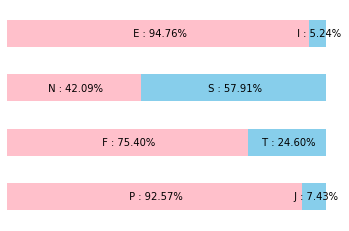


                  ESFP 입니다














In [ ]:
mbti_predict(text)